In [1]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline

sys.path.append('..')
sys.path.append('../src_cython')
from zwatershed import zwatershed_and_metrics
from z_watershed import *
from visualization.visualize_funcs import *

path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'

start = time.clock()
threshes = [2000]
hdf5_gt_file = path_to_data + 'groundtruth_seg_thick.h5'  # /groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
hdf5_pred_file = path_to_data + 'tstvol-1_2.h5'  # /tier2/turaga/singhc/train/output_200000/tstvol-1_2.h5'
out = path_to_data + 'out/'  # '/groups/turaga/home/singhc/evaluation/out/'
save_threshes = threshes
rand = 0
p1, p2, p3 = 215,180,180# 215, 214, 214

hdf5_gt = h5py.File(hdf5_gt_file, 'r')
hdf5_aff = h5py.File(hdf5_pred_file, 'r')
gt = np.asarray(hdf5_gt[hdf5_gt.keys()[0]], dtype='uint32')
aff = np.asarray(hdf5_aff[hdf5_aff.keys()[0]], dtype='float32')
print 'gt,aff shapes',gt.shape,aff.shape
aff = aff[:, p1:(-1 * p1), p2:(-1 * p2), p3:(-1 * p3)]
gt = trim_arbitrary_aff(gt, aff)
print 'gt,aff shapes',gt.shape,aff.shape

nhood = mknhood3d(1)
node1, node2, edge_affs = affgraph_to_edgelist(aff, nhood)
print "len node1", len(node1)
print "n1,n2,edge", min(node1), max(node1), min(node2), max(node2), min(edge_affs), max(edge_affs)
print "\noriginal watershed..."
seg_one, segs_old, rand = zwatershed_and_metrics(gt, aff, threshes, save_threshes)

print "\nnew watershed..."
segs_new = zwatershed_and_metrics_edge(gt, np.array(node1, dtype='uint32'), np.array(node2, dtype='uint32'),
                                       np.array(edge_affs), threshes, save_threshes)

print rand
print "time: ", time.clock() - start

gt,aff shapes (520, 520, 520) (3, 432, 432, 432)
gt,aff shapes (2, 72, 72) (3, 2, 72, 72)
len node1 25629
n1,n2,edge 2 10367 1 10366 1.63987e-06 1.0

original watershed...

new watershed...
[5185 5186 5187 5188 5189 5190 5191 5192 5193 5194] [ 1  2  3  4  5  6  7  8  9 10] [ 0.9999938   0.99998355  0.99994826  0.99978381  0.99906594  0.99672359
  0.99295723  0.98523164  0.89687669  0.12097168]
stats: [0.40714853057982525, 0.09847466092903523]
{'V_Rand_merge': [1.0], 'V_Rand_split': [0.5173007073217358], 'V_Rand': 0.6818697240771072}
time:  1.068382


In [2]:
## Open training data and labels
data_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/data/'# 'nobackup/turaga/data/FlyEM/fibsem_medulla_7col/tstvol-520-1/'
os.chdir('/.')
f = h5py.File(data_folder + 'im_uint8.h5', 'r')
im = f[f.keys()[0]] # was 'main'
g = h5py.File(data_folder + 'groundtruth_aff.h5', 'r')
label_set = np.asarray(g[g.keys()[0]],dtype='float32') #3,z,y,x - was 'main'
label_set = np.transpose(label_set,(1,2,3,0))

(2, 72, 72) (2, 72, 72, 3) (2, 72, 72)
(2, 72, 72) (2, 72, 72, 3) (2, 72, 72)
old num 13 new num 21


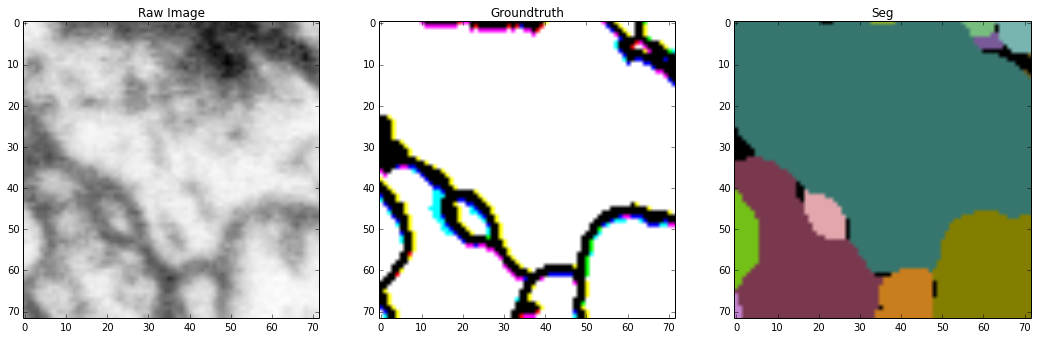

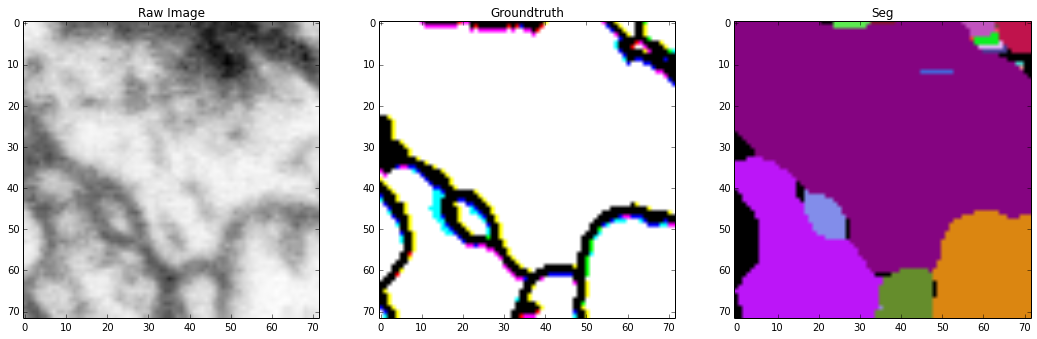

In [6]:
# view segs
seg_old = segs_old[0]#seg_one
seg_new = segs_new[1]
# im,label_set=trim(im,label_set,seg) 
# seg = seg.transpose((2, 1, 0)).reshape(shape).transpose((2, 1, 0))
print im.shape,label_set.shape,seg_new.shape
im,label_set=trim_arbitrary(im,label_set,seg_new) 
print im.shape,label_set.shape,seg_new.shape
print "old num",len(np.unique(seg_old)),"new num",len(np.unique(seg_new))
# display_seg(im, label_set, seg, im_size=label_set.shape[0], im2_size=seg.shape[0])
display_arbitrary_seg(im, label_set, seg_old)
display_arbitrary_seg(im, label_set, seg_new)

In [14]:
seg_flat = seg_new.flatten()
seg_old_flat = seg_old.flatten()
print min(seg_flat)
print max(seg_flat)
print sum(seg_flat==0)
print sum(seg_old_flat==0)
# print seg_old

0
10328
6436
1


In [21]:
print node1, node2, edge_affs

[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  5  6  7  8  9 10 11 12 13 14
 15 20 21 22 23 24 25 26 27 28 29 30 31  2  3  5  6  7  9 10 11 13 14 15 17
 18 19 21 22 23 25 26 27 29 30 31] [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  1  2  3  4  5  6  7  8  9 10
 11 16 17 18 19 20 21 22 23 24 25 26 27  1  2  4  5  6  8  9 10 12 13 14 16
 17 18 20 21 22 24 25 26 28 29 30] [ 0.99995029  0.99998677  0.99999285  0.99982649  0.9999404   0.9999814
  0.99999022  0.99982977  0.99992788  0.99997401  0.99998486  0.99984777
  0.99992263  0.9999665   0.99997699  0.99999559  0.99999857  0.99999917
  0.99998748  0.99999559  0.99999845  0.99999917  0.99998605  0.99999464
  0.99999809  0.99999893  0.99997532  0.99999285  0.99999809  0.99999905
  0.99997497  0.9999913   0.99999738  0.99999845  0.99997652  0.99999034
  0.99999654  0.99999785  0.99999952  0.99999976  0.99999809  0.99999952
  0.99999976  0.99999797  0.9999994   0.99999976  0.99999738  0.99999917
  0.99999964  0.99999762  0.99999952  0.999